# Generative Adverserial Network Usage for Gene Similarity Measures

In [58]:
from geneGAN_use import geneGAN_model
import numpy as np
import matplotlib.pyplot as plt

## Input
Three inputs are needed to study gene similarities with a trained GAN.

__cosmic_census_path__: This file contains all genes (and synonyms) used in gene training in alphabetic order. This ordering is also used to encode the genes in binary vectors.

__model_path__: This is the path to a saved GAN model. The two listed paths correspond to a model trained on COSMIC cancer patient data and to a model trained on co-occurring genes in PubMed abstracts.

__setting__: This dictionary contains information on the GAN structure.


In [59]:
cosmic_census_path = 'data/cosmic_cancer_gene_census.txt'
model_cosmic = 'trainings/training_277/training_277'
model_pubmed = 'trainings/training_283/training_283'

setting   = {'inputDim':614,
             'embeddingDim':256,
             'randomDim':256,
             'compressDims':[],
             'decompressDims':[],
             'generatorDims':(256, 256),
             'discriminatorDims':(256, 128, 1)}

ggan = geneGAN_model(**setting)


In [51]:
def importCosmicGenes(filepath):
    genes = []
    synonyms = []
    with open(filepath, 'r') as f:
        lines = f.readlines()
    for line in lines:
        gene_raw, synonyms_raw = line.split('\t')
        genes.append(gene_raw)
        synonyms.append(synonyms_raw.strip('\n').split(','))
    return genes, synonyms

def geneToIntMap(genes, synonyms):
    mapper={}
    for i, (gene,syns) in enumerate(zip(genes, synonyms)):
        mapper[gene]=i
        for s in syns:
            mapper[s]=i
    return mapper

def genePairToVector(gene1, gene2, mapper, dim):
    vec = np.zeros(dim)
    if gene1 in mapper:
        vec[mapper[gene1]]=1
    if gene2 in mapper:    
        vec[mapper[gene2]]=1
    return vec

## Gene Encoding
This block imports all genes from the cosmic cancer gene census and sets up a mapper from gene names onto integers corresponding to the position in the gene list. This map is used to map gene names to binary vectors

In [52]:
genes, synonyms = importCosmicGenes(cosmic_census_path)
dim = len(genes)
geneMap = geneToIntMap(genes, synonyms)

## Example
Two gene pairs are encoded in two-hot vectors.

In [53]:
data = []
data.append(genePairToVector('TP53', 'EGFR', geneMap, dim))
data.append(genePairToVector('ZNF521', 'ZRSR2', geneMap, dim))
data = np.array(data)

We can use the 'discriminateData' function to get the Discriminator output for each pair. The second argument is used when in batch mode (single=False) and then corresponds to the mean batch vector.

In [54]:
y_hat =  ggan.discriminateData(data, 0, modelFile=model_cosmic, single=True)
print('Discriminator evalutation of TP53,EGFR:\t\t',y_hat[0])
print('Discriminator evalutation of ZNF521,ZRSR2:\t',y_hat[1])

Discriminator evalutation of TP53,EGFR:		 0.958157
Discriminator evalutation of ZNF521,ZRSR2:	 0.153947


## Embeddings
To get the discriminator's embedding vectors for a gene pair are obtained with the 'getDiscEmbeddings' function, which returns a dictionary. The key '0' corresponds to the vector after the first layer and '1' to the second layer (the enumeration goes on if more layers were trained).

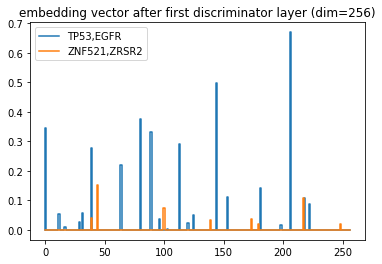

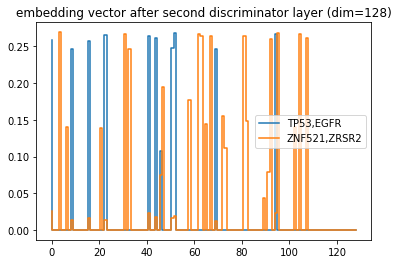

In [61]:
embeddings_in = ggan.getDiscEmbeddings(data, modelFile=model_cosmic)

emb_dim = len(embeddings_in['0'][0])
plt.step(np.linspace(0,emb_dim,emb_dim),embeddings_in['0'][0], label='TP53,EGFR')
plt.step(np.linspace(0,emb_dim,emb_dim),embeddings_in['0'][1], label='ZNF521,ZRSR2')
plt.title('embedding vector after first discriminator layer (dim=256)')
plt.legend(loc='best')
plt.show()

emb_dim = len(embeddings_in['1'][0])
plt.step(np.linspace(0,emb_dim,emb_dim),embeddings_in['1'][0], label='TP53,EGFR')
plt.step(np.linspace(0,emb_dim,emb_dim),embeddings_in['1'][1], label='ZNF521,ZRSR2')
plt.title('embedding vector after second discriminator layer (dim=128)')
plt.legend(loc='best')
plt.show()